In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin

class Palanthir(object):
## Native attributes
    def __init__(self, input, target_feature:str=None, init_test_size:(float,None)=None):
        """Initiates a Palanthir-class on-top a Pandas Dataframe. The class-attributes describes the overall structure and composition of the data"""
        self.input_data = input
        ##When the Palanthir is born with a target variable:
        if isinstance(target_feature,str):
        #...AND is to be split into test-train subsets
            self.Y_col = [target_feature]
            self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
            if isinstance(init_test_size,float):
                self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.input_data[self.X_cols],self.input_data[self.Y_col],test_size=0.2,random_state=42)
                self.output = self.train_X.copy(deep=True)
        #...BUT IS NOT to be split into test-train subsets
            else:
                self.Y = self.input_data.copy(deep=True)[self.Y_col]
                self.X = self.input_data.copy(deep=True)[self.X_cols]
                self.output = self.X.copy(deep=True)
        ##When the Palanthir is NOT born with a target variable:
        else:
        # ...BUT IS to be split into test-train subsets
            if isinstance(init_test_size,float):
                self.train, self.test = train_test_split(self.input_data,test_size=0.2,random_state=42)
                self.output = self.train.copy(deep=True)
        #...AND IS NOT to be split into test-train subsets.
            else:
                self.output = self.input_data.copy(deep=True)
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
        self.current_version = 0
        self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=ColumnTransformer([]))]

## Self-update and audit commands

    def update_attributes(self):
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])

    def update_history(self, step=None, snapshot=None,transformer=None,cols=None):
        current_pipeline = self.transformation_history[-1].get('pipeline').get_params().get('transformers')
        ## Pair together columns and transformers from pipelines used in the ColumnTransformer
        trans_col_pairs = [(item,tup[2]) for tup in current_pipeline for item in tup[1].steps]
        ## Insert the new step from added transformer
        step_order = '1' if [step[0] for pip in current_pipeline for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in current_pipeline for step in pip[1].steps]) + 1)
        new_trans = ((step_order,transformer),cols)
        trans_col_pairs += [new_trans]
        ## Explode each transformer and each column for individual trans-on-col-pairs
        col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
        ## Collect to list all transformers on each column
        sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
        col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
        ## Collect to list all columns on each identical list of transformers
        sort_on_steps = sorted(col_trans_collect,key=lambda x: x[1])
        new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
        ## Wrap transformers into pipeline and pipelines into ColumnTransformer
        list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
        ## Update the Transformation History-dictionary
        updatedPipeline = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=updatedPipeline
            )
        )

    def restore(self, version=None):
        versionCheckpoint = (self.current_version - 1) if version == None else version
        self.current_version = versionCheckpoint
        self.output = self.transformation_history[versionCheckpoint].get('result')
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Restored to version {self.current_version}"
                ,result=self.transformation_history[self.current_version].get('result')
                ,pipeline=self.transformation_history[self.current_version].get('pipeline')
            )
        )
        return self.transformation_history[self.current_version].get('pipeline')

    def declare_target(self,target_feature:str):
        self.current_version += 1
        self.Y_col = [target_feature]
        self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
        ## Palanthir has already been split into test-train subsets:
        if hasattr(self,'train') or hasattr(self,'test'):
            self.train_X = self.train[self.X_cols]
            self.train_Y = self.train[self.Y_col]
            self.test_X = self.test[self.X_cols]
            self.test_Y = self.test[self.Y_col]
            self.output = self.train_X.copy(deep=True)
            del self.train, self.test
        ## Palanthir has NOT already been split into test-train subsets:
        else:
            self.Y = self.input_data.copy(deep=True)[self.Y_col]
            self.X = self.input_data.copy(deep=True)[self.X_cols]
            self.output = self.X.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into X and Y"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.Y_col

    def random_split(self, test_size=0.2):
        """Uses the SKLearn Train_Test_Split to divide the dataset into random training and test subset"""
        from sklearn.model_selection import train_test_split
        self.current_version += 1
        ## Palanthir is already split into X-Y features:
        if hasattr(self,'Y') or hasattr(self,'X'):
            self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.X,self.Y,test_size=test_size,random_state=42)
            self.output = self.train_X.copy(deep=True)
        ## Palanthir is NOT already split into X-Y features:
        else:
            self.train, self.test = train_test_split(self.input_data,test_size=test_size,random_state=42)
            self.output = self.train.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into Test and Train"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.output

## Summarization and description commands
    def summarize(self):
        """Prints the info, description and any missing value-counts for the class"""
        dataset = self.output
        return print(
            "Info: ", dataset.info(),
            "\n",
            "Description: ", dataset.describe(),
            "\n",
            "Missing values: ", dataset.isna().sum()

        )

## Data preprocessing commands

    ## TO BE DEVELOPED
    def stratified_split(self, cols, store=True):
        """Uses the SKLearn StratigiesShuffleSplit to divide the dataset into stratified training and test subset"""
        dataset = self.output
        from sklearn.model_selection import StratifiedShuffleSplit
        split = StratifiedShuffleSplit(n_split=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(dataset, dataset[cols]):
            strat_train_set = dataset.loc[train_index]
            strat_test_set = dataset.loc[test_index]
        if store:
            self.train_subset, self.test_subset = [strat_train_set], [strat_test_set]
        return strat_train_set, strat_test_set

    def execute_pipeline(self, dataset=None, pipeline_version=None):
        """Uses the SKLearn ColumnTransformer build via previous transformations and apply its transformations to the target dataset"""
        versionCheckpoint = self.current_version if pipeline_version == None else pipeline_version
        pipeline = self.transformation_history[versionCheckpoint].get('pipeline')
        ## Check if a dataset is given at function-runtime
        if isinstance(dataset,pd.core.frame.DataFrame):
            dataset = dataset
            fitted_pipeline = pipeline.fit(self.input_data)
        ## Alternatively check if the Palanthir has already got a X-Y split in its test-train subsets:
        else:
            dataset = self.test_X if hasattr(self,'test_X') else self.test
            fitted_pipeline = pipeline.fit(self.train_X) if hasattr(self,'train_X') else pipeline.fit(self.test)
        self.transformed_test = fitted_pipeline.set_output(transform='pandas').transform(dataset)
        return self.transformed_test

## Transformation commands
    def PCA(self, n_components=0.80, include_features = [], exclude_features=[],store=True):
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.decomposition import PCA
        transformer = PCA(n_components=n_components).fit(dataset)
        pca_data = transformer.transform(dataset)
        output_df = pd.DataFrame(pca_data, columns=["PCA_" + str(col + 1) for col in range(pca_data.shape[1])],index=dataset.index)
        if store:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Performed Principal Component Analysis",snapshot=self.output,transformer=transformer,cols=columns)
        explained_variance = PCA().fit(dataset).explained_variance_ratio_
        cumsum = np.cumsum(explained_variance)
        print(cumsum)
        plt.plot(["PCA" + str(num) for num in range(1, len(cumsum) + 1)], cumsum)
        plt.show()
        return output_df

    def fill_nulls(self, strategy="median", include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn SimpleImputer to fill out any missing values in the numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.impute import SimpleImputer
        transformer = SimpleImputer(strategy=strategy).fit(dataset)
        imputed_data = transformer.transform(dataset)
        output_df = pd.DataFrame(imputed_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Filled nulls",snapshot=self.output,transformer=transformer,cols=columns)
        return output_df

    def encode_order(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OrdinalEncoder to order any categorical features of the dataset"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import OrdinalEncoder
        transformer = OrdinalEncoder().fit(dataset)
        encoded_data = transformer.transform(dataset)
        output_df = pd.DataFrame(encoded_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step="Encoded order of categorial features",snapshot=self.output,transformer=transformer,cols=columns)
        return output_df

    def make_dummies(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OneHotEncoder to turn categorical features of the dataset into dummy-variables"""
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        remain_columns = [col for col in self.output.columns if col not in columns]
        dataset = self.output[columns]
        from sklearn.preprocessing import OneHotEncoder
        transformer = OneHotEncoder().fit(dataset)
        new_column_names = transformer.get_feature_names_out(dataset.columns)
        dummy_data = transformer.transform(dataset).toarray()
        dummy_data_df = pd.DataFrame(dummy_data, columns=[name for name in new_column_names], index=dataset.index)
        output_df = pd.merge(self.output[remain_columns], dummy_data_df, left_index=True, right_index=True)
        if store == True:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Turned categorical features into dummy variables",snapshot=self.output,transformer=transformer,cols=columns)
        return output_df

    def scale(self, strategy:str, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn StandardScaler or MinMaxScaler to scale all numerical features of the dataset"""
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        if strategy=="Standard":
            transformer = StandardScaler().fit(dataset)
        elif strategy=="MinMax":
            transformer = MinMaxScaler().fit(dataset)
        else:
            print('Not a proper scaler')
        output_df = transformer.transform(dataset)
        if store:
            self.output[columns] = output_df
            self.update_attributes()
            self.update_history(step=f"""Scaled feature-values using {'Standard-scaler' if strategy=='Standard' else 'MinMax-scaler'}""",snapshot=self.output,transformer=transformer,cols=columns)
        return output_df

    def cluster(self, max_k=10, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        from sklearn.base import BaseEstimator,TransformerMixin
        from sklearn.cluster import KMeans
        from sklearn.utils import check_random_state
        from sklearn.metrics import silhouette_score
        from matplotlib import pyplot

        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
        ## Create Custom Transformer for updating Cluster-label column
            class ClusterIdentifier(BaseEstimator,TransformerMixin):
                def __init__(self, Ks=best_k,random_state=None):
                    self.random_state = random_state
                    self.Ks = Ks

                def fit(self, X, y=None):
                    self.random_state_ = check_random_state(self.random_state)
                    self.estimator = KMeans(n_clusters=self.Ks, n_init='auto', random_state=42).fit(X)
                    return self

                def transform(self, X, y=None):
                    X_trans = pd.DataFrame(data=self.estimator.transform(X)).apply(lambda x: x.astype(float))
                    X_trans['cluster'] = X_trans.idxmin(axis=1)
                    return X_trans

                def get_feature_names_out(self):
                    pass

            bestKMeans = KMeans(n_clusters=best_k, random_state=42).fit(dataset)
            #self.output["Cluster"] = ["Cluster " + str(i) for i in bestKMeans.predict(dataset)]
            transformer = ClusterIdentifier().fit(dataset)
            self.output = transformer.transform(X=dataset)
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output,transformer=transformer,cols=columns)
        return self.output

    def remove_outliers(self, include_features = [], exclude_features = [], factor=1.5):
        from sklearn.base import BaseEstimator,TransformerMixin
        class OutlierRemover(BaseEstimator,TransformerMixin):
            def __init__(self,factor=factor):
                self.factor = factor

            def outlier_detector(self,X,y=None):
                X = pd.Series(X).copy()
                q1 = X.quantile(0.25)
                q3 = X.quantile(0.75)
                iqr = q3 - q1
                self.lower_bound.append(q1 - (self.factor * iqr))
                self.upper_bound.append(q3 + (self.factor * iqr))

            def fit(self,X,y=None):
                self.lower_bound = []
                self.upper_bound = []
                X.apply(self.outlier_detector)
                return self

            def transform(self,X,y=None):
                X = pd.DataFrame(X).copy()
                for i in range(X.shape[1]):
                    x = X.iloc[:, i].copy()
                    x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
                    X.iloc[:, i] = x
                return X
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]



## Analysis commands
    def cross_validate(self, model, x, y, score_measure="neg_mean_squared_error", folds=10):
        """Uses the SKLearn Cross_Val_Score to cross-validate one/several models on the training subset"""
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, x, y, scoring=score_measure, cv=folds)
        return scores

    def full_analysis(self, model):
        """Conducts a full data-analysis pipeline on the dataset, including model training, evaluation and tuning"""
        dataset = self.output
        X_train, X_test, Y_train, Y_test = self.random_split(dataset)

        sqrt_scores = np.sqrt(-self.cross_validate(model, X_train, Y_train, score_measure="neg_mean_squared_error", folds=10))
        print(
            "RMSE-scores: ", sqrt_scores,
            "RMSE-mean: ", sqrt_scores.mean(),
            "RMSE-std: ", sqrt_scores.std()
        )

# **Declare the Palanthir-object on the input dataframe**

In [316]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)

In [317]:
pal = Palanthir(df
                #,target_feature='ocean_proximity'
                ,init_test_size=0.2
    )

# **Preliminary analysis**

In [318]:
pal.summarize()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
Info:  None 
 Description:            longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.582290     35.643149           28.608285   2642.004784   
std   

In [319]:
print(
    f"Target-variable is set to: {pal.Y_col}",
    "\n",
    f"Explanatory variables are set to: {pal.X_cols}",
    "\n"
)

AttributeError: 'Palanthir' object has no attribute 'Y_col'

# **Apply transformations**

## Fill out nulls

In [320]:
pal.fill_nulls(strategy="median")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0
...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0


## Scale numerical features

In [321]:
pal.scale(strategy="MinMax",exclude_features=['longitude','latitude'])

array([[0.62745098, 0.0794547 , 0.09714463, ..., 0.10228581, 0.19032151,
        0.18144461],
       [0.94117647, 0.08596572, 0.12197393, ..., 0.12415721, 0.22845202,
        0.75690616],
       [0.05882353, 0.04819675, 0.05121043, ..., 0.05508962, 0.25216204,
        0.32494918],
       ...,
       [0.68627451, 0.05338522, 0.08814401, ..., 0.08649893, 0.16789424,
        0.42701061],
       [0.2745098 , 0.09087441, 0.09248914, ..., 0.09176122, 0.35994676,
        0.55360803],
       [1.        , 0.10743171, 0.20391061, ..., 0.20407828, 0.14314285,
        0.63917468]])

## Encode Order

In [322]:
pal.encode_order()

,ocean_proximity
14196,4.0
8267,4.0
17445,4.0
14265,4.0
2271,1.0
...,...
11284,0.0
11964,1.0
5390,0.0
860,0.0


## Add Cluster-label

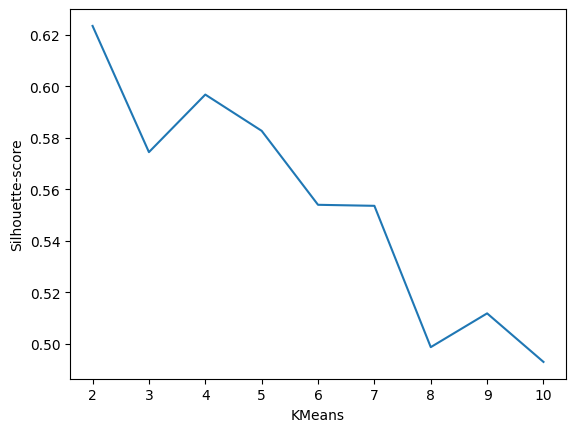

Best silhouette is obtained with k as:  2


c:\Users\JesperFrederiksen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,cluster
0,3.567776,7.434189,0
1,3.240947,6.014975,0
2,4.122646,4.275716,0
3,3.559445,7.400596,0
4,3.374468,2.372650,1
...,...,...,...
16507,0.862207,5.863983,0
16508,0.670815,5.868620,0
16509,0.909484,5.416859,0
16510,5.434097,1.729662,1


In [312]:
pal.cluster()

## Apply steps to Test

In [323]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', MinMaxScaler())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2',
                                 Pipeline(steps=[('3', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

In [324]:
pal.execute_pipeline()

c:\Users\JesperFrederiksen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


,latitude,longitude,households,housing_median_age,median_house_value,median_income,population,total_bedrooms,total_rooms,ocean_proximity
20046,36.06,-119.01,0.068826,0.470588,0.067424,0.081468,0.085888,0.077894,0.039519,1.0
3024,35.14,-119.46,0.112204,0.568627,0.063507,0.140095,0.096624,0.077894,0.077430,1.0
15663,37.80,-122.44,0.185271,1.000000,1.000000,0.205528,0.080799,0.077894,0.100815,3.0
20484,34.28,-118.72,0.095045,0.313725,0.419794,0.361216,0.105312,0.077894,0.080277,0.0
9814,36.62,-121.93,0.082128,0.647059,0.542268,0.222418,0.065471,0.077894,0.061823,4.0
...,...,...,...,...,...,...,...,...,...,...
15362,33.36,-117.22,0.086755,0.294118,0.511959,0.283106,0.083344,0.087767,0.083283,0.0
16623,35.36,-120.83,0.135531,0.529412,0.519175,0.153563,0.101899,0.161638,0.113812,4.0
18086,37.31,-122.05,0.109119,0.470588,1.000000,0.602054,0.097865,0.098007,0.108223,0.0
2144,36.77,-119.76,0.090997,0.686275,0.118146,0.157591,0.075649,0.084842,0.065936,1.0


In [303]:
pal.transformed_test.shape

(4128, 10)